# Основные точки тела

Для обнаружения ключевых точек тела среди различных архитектур и подходов на сегодняшний день можно выделить несколько лидеров. Одним из наиболее успешных вариантов является YOLOv8 Pose, модификация архитектуры YOLO, предназначенная для обнаружения ключевых точек позы человека. Этот метод объединяет преимущества быстрого обнаружения объектов с точностью обнаружения ключевых точек.

Еще одним мощным инструментом является библиотека MediaPipe от Google, предоставляющая высокоэффективные решения для обнаружения и отслеживания ключевых точек тела в реальном времени. MediaPipe удобен для создания приложений, работающих на мобильных устройствах и веб-камерах.

OpenPose - это классическая архитектура, которая остается одним из лидеров в области обнаружения ключевых точек тела. Она имеет обширное сообщество и поддерживается множеством библиотек, что делает ее хорошим выбором для широкого круга приложений.

При выборе подхода или архитектуры для обнаружения ключевых точек тела, стоит учитывать специфику задачи, требования к скорости и доступные ресурсы, чтобы определить, какой из этих методов будет наилучшим для вашего проекта.

# 1. YOLOv8-pose

In [3]:
import cv2
from ultralytics import YOLO
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
list_point_names = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder",
                    "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist",
                    "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"]
len(list_point_names)

17

готовый пример без трекинга по данным с камеры от YOLOv8:

In [4]:
#model = YOLO('yolov8m-pose.pt') 
#model(source=0, show=True, conf=0.3, iou=0.7, verbose=False)

## Анализ изображений:


0: 448x640 5 persons, 20.8ms
Speed: 15.6ms preprocess, 20.8ms inference, 17.3ms postprocess per image at shape (1, 3, 448, 640)


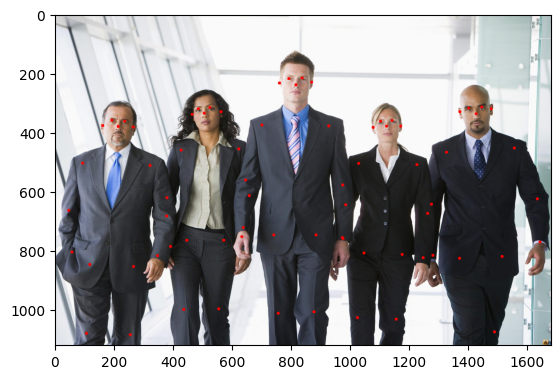

In [3]:
model = YOLO('yolov8m-pose.pt')  # load a pretrained model (recommended for training)
image = cv2.imread('images/test.jpg')  # Замените 'ваше_изображение.jpg' на имя вашего изображения
results = model.predict(image, iou=0.4, conf=0.5)

for i in range(len(results[0].keypoints.xy)):
    keypoints = results[0].keypoints.xy[i]
    for j, point in enumerate(keypoints):
        x, y = point
        if x >= 0 and y >= 0:
            cv2.circle(image, (int(x), int(y)), 5, (0,0,255), -1)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(image);

In [4]:
list_point_names = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder",
                    "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist",
                    "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"]

In [5]:
point_pairs = [
    (5, 7), (7, 9), (11, 13), (13, 15),  # Левая и правая руки
    (5, 11), (6, 12), # Торс
    (11, 12), # Между ног
    (0, 1), (0, 2), (1, 3), (2, 4),  # Голова
    (5, 6),  # Соединение плечей
    (5, 7), (7, 9),  # Левая рука
    (6, 8), (8, 10),  # Правая рука
    (11, 13), (13, 15),  # Нога левая
    (12, 14), (14, 16)  # Нога правая
]


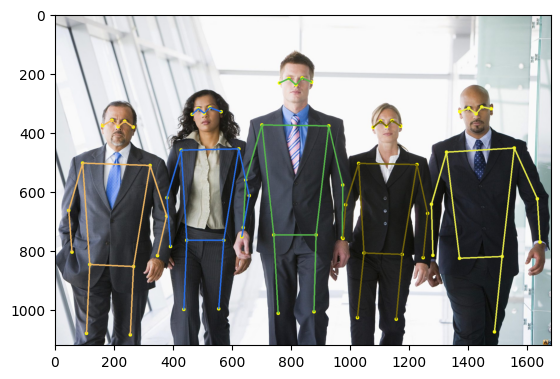

In [6]:
import cv2
import matplotlib.pyplot as plt

model = YOLO('yolov8m-pose.pt')  # load a pretrained model (recommended for training)
image = cv2.imread('test.jpg')  # Замените 'ваше_изображение.jpg' на имя вашего изображения
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # YOLO требует BGR
results = model.predict(image, iou=0.4, conf=0.3, verbose=False,)


for i in range(len(results[0].keypoints.xy)):
    keypoints = results[0].keypoints.xy[i]

    random.seed(int(i+100))
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    # Рисуем точки
    for j, point in enumerate(keypoints):
        x, y = point
        if x > 0 and y > 0:  # Проверяем, что обе координаты больше нуля
            cv2.circle(image, (int(x), int(y)), 6, (0, 255, 255), -1)

    # Соединяем точки линиями
    for pair in point_pairs:
        start, end = pair
        if keypoints[start][0] > 0 and keypoints[start][1] > 0 and keypoints[end][0] > 0 and keypoints[end][1] > 0:  # Проверяем, что обе пары координат больше нуля
            x1, y1 = int(keypoints[start][0]), int(keypoints[start][1])
            x2, y2 = int(keypoints[end][0]), int(keypoints[end][1])
            cv2.line(image, (x1, y1), (x2, y2), color, 3)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(image)  # Отображение изображения с точками и линиями
plt.show()

## Анализ видео + трекинг

In [19]:
def process_video_with_tracking(model, input_video_path, show_video=True, save_video=False, output_video_path="output_video.mp4"):
    # Open the input video file
    cap = cv2.VideoCapture(input_video_path)

    if not cap.isOpened():
        raise Exception("Error: Could not open video file.")

    # Get input video frame rate and dimensions
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the output video writer
    if save_video:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps/2, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        results = model.track(frame, iou=0.4, conf=0.5, persist=True, imgsz=608, verbose=False, tracker="botsort.yaml")

        if results[0].boxes.id != None: # this will ensure that id is not None -> exist tracks
            boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
            ids = results[0].boxes.id.cpu().numpy().astype(int)

            for box, id in zip(boxes, ids):
                # Generate a random color for each object based on its ID
                random.seed(int(id))
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3],), color, 2)
                cv2.putText(
                    frame,
                    f"Id {id}",
                    (box[0], box[1]),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (0, 255, 255),
                    2,
                )

            for i, id in enumerate(ids):
                keypoints = results[0].keypoints.xy[i]

                random.seed(int(id))
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

                # Рисуем точки
                for j, point in enumerate(keypoints):
                    x, y = point
                    if x > 0 and y > 0:  # Проверяем, что обе координаты больше нуля
                        cv2.circle(frame, (int(x), int(y)), 3, (0, 255, 255), -1)

                # Соединяем точки линиями
                for pair in point_pairs:
                    start, end = pair
                    if keypoints[start][0] > 0 and keypoints[start][1] > 0 and keypoints[end][0] > 0 and keypoints[end][1] > 0:  # Проверяем, что обе пары координат больше нуля
                        x1, y1 = int(keypoints[start][0]), int(keypoints[start][1])
                        x2, y2 = int(keypoints[end][0]), int(keypoints[end][1])
                        cv2.line(frame, (x1, y1), (x2, y2), color, 2)

        if save_video:
            out.write(frame)

        if show_video:
            cv2.imshow("frame", frame)

        if cv2.waitKey(int(1000/fps)) & 0xFF == ord("q"):
            break

    # Release the input video capture and output video writer
    cap.release()
    if save_video:
        out.release()

    # Close all OpenCV windows
    cv2.destroyAllWindows()



# Load a model
model = YOLO('yolov8m-pose.pt')  # load a pretrained model (recommended for training)
process_video_with_tracking(model, "city.mp4", show_video=True, save_video=True, output_video_path="output_video.mp4")


## Обработка потока с видеокамеры

In [11]:
def process_video_with_tracking(model, cap_number, show_video=True):
    cap = cv2.VideoCapture(cap_number)

    if not cap.isOpened():
        raise Exception("Error: Could not open video capture.")

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        results = model.track(frame, iou=0.4, conf=0.5, persist=True, imgsz=608, verbose=False, tracker="botsort.yaml")

        if results[0].boxes.id is not None:  # this will ensure that id is not None -> exist tracks
            boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
            ids = results[0].boxes.id.cpu().numpy().astype(int)

            for box, id in zip(boxes, ids):
                # Generate a random color for each object based on its ID
                random.seed(int(id))
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), color, 2)
                cv2.putText(
                    frame,
                    f"Id {id}",
                    (box[0], box[1]),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (0, 255, 255),
                    2,
                )

            for i, id in enumerate(ids):
                keypoints = results[0].keypoints.xy[i]

                random.seed(int(id))
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

                # Рисуем точки
                for j, point in enumerate(keypoints):
                    x, y = point
                    if x > 0 and y > 0:  # Проверяем, что обе координаты больше нуля
                        cv2.circle(frame, (int(x), int(y)), 3, (0, 255, 255), -1)

                # Соединяем точки линиями
                for pair in point_pairs:
                    start, end = pair
                    if keypoints[start][0] > 0 and keypoints[start][1] > 0 and keypoints[end][0] > 0 and keypoints[end][1] > 0:  # Проверяем, что обе пары координат больше нуля
                        x1, y1 = int(keypoints[start][0]), int(keypoints[start][1])
                        x2, y2 = int(keypoints[end][0]), int(keypoints[end][1])
                        cv2.line(frame, (x1, y1), (x2, y2), color, 2)

        cv2.imshow("frame", frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    # Release the input video capture
    cap.release()

    # Close all OpenCV windows
    cv2.destroyAllWindows()

# Load a model
model = YOLO('yolov8m-pose.pt')  # load a pretrained model (recommended for training)
process_video_with_tracking(model, 1, show_video=True)


# 2. MediaPipe

 [YOLOv7 Pose vs MediaPipe](https://www.youtube.com/watch?v=hCJIU0pOl5g&t=373s)

Модель Pose от Mediapipe обнаруживает позу человека, но она может быть использована для обнаружения позы лишь одного человека.

In [2]:
#pip install opencv-python mediapipe msvc-runtime
import mediapipe as mp
import time

<p align="center">
  <img src="images/body_landmarks.png" alt="точки тела">
</p>


Пример обработки фотографии:

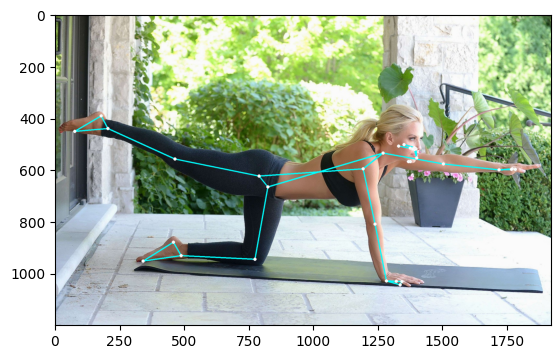

In [10]:
# Инициализация Mediapipe Pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(model_complexity=2)

# Загрузка изображения
image_path = 'images/yoga.jpg'
image = cv2.imread(image_path)
height, width, _ = image.shape

# Обнаружение позы на изображении
results = pose.process(image)

# Отображение изображения с обнаруженной позой
mp_drawing.draw_landmarks( 
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(   # точки 
          color=(255,255,255),
          thickness=3,
          circle_radius=3
        ),
        mp_drawing.DrawingSpec(  # линии соединения
          color=(255,255,0),
          thickness=3,
          circle_radius=2
        )
    )

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(image)  # Отображение изображения с точками и линиями
plt.show()

Пример обработки числа раз поднятия правой руки с использованием mediapipe pose модели

In [7]:
import cv2
import mediapipe as mp
import time
mp_drawing = mp.solutions.drawing_utils
drawSpecific = mp.solutions.pose
mp_pose = mp.solutions.pose

def distanceCalculate(p1, p2):
    """p1 and p2 in format (x1,y1) and (x2,y2) tuples"""
    dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
    return dis


start = True
count = 0

# For webcam input:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

with mp_pose.Pose(
    min_detection_confidence=0.7,
    min_tracking_confidence=0.5,
    model_complexity=2) as pose:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    image.flags.writeable = False
    results = pose.process(image)
    image.flags.writeable = True


    image_height, image_width, _ = image.shape
    if results.pose_landmarks != None:
        
        nosePoint = (int(results.pose_landmarks.landmark[0].x*image_width), int(results.pose_landmarks.landmark[0].y*image_height), results.pose_landmarks.landmark[0].visibility)
        leftWrist = (int(results.pose_landmarks.landmark[15].x*image_width), int(results.pose_landmarks.landmark[15].y*image_height), results.pose_landmarks.landmark[15].visibility)
        rightWrist = (int(results.pose_landmarks.landmark[16].x*image_width), int(results.pose_landmarks.landmark[16].y*image_height), results.pose_landmarks.landmark[16].visibility)
        leftShoulder = (int(results.pose_landmarks.landmark[11].x*image_width), int(results.pose_landmarks.landmark[11].y*image_height), results.pose_landmarks.landmark[11].visibility)
        rightShoulder = (int(results.pose_landmarks.landmark[12].x*image_width), int(results.pose_landmarks.landmark[12].y*image_height), results.pose_landmarks.landmark[12].visibility)
        

        if nosePoint[2] > 0.5 and rightWrist[2] > 0.5:   # проверка на наличие
          if nosePoint[1] <= rightWrist[1]:
              start = True # при опускании руки переводит счетчик в режим нового ожидания
          elif start  and nosePoint[1] > rightWrist[1]:
              count += 1
              start = False

    # Drawing the Facial Landmarks
    mp_drawing.draw_landmarks( 
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(   # точки 
          color=(255,255,255),
          thickness=3,
          circle_radius=2
        ),
        mp_drawing.DrawingSpec(  # линии соединения
          color=(0,255,255),
          thickness=2,
          circle_radius=1
        )
    )
  
    text = f"Правая рука поднята столько раз: {count}" 
    image = cv2.putText(image, text, (50, 50), fontFace=cv2.FONT_HERSHEY_COMPLEX,
                         fontScale=1, color=(255, 0, 0), thickness=1, lineType=cv2.LINE_AA)

    cv2.imshow('MediaPipe Pose', image)
    if cv2.waitKey(1) & 0xFF == ord("q"):
      break
    
cap.release()
cv2.destroyAllWindows()

In [6]:
results.pose_landmarks.landmark[30]

x: 0.3091294765472412
y: 2.3439488410949707
z: -0.16192319989204407
visibility: 0.004053656477481127